**Sub. 1**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import networkx as nx

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**1.**

In [2]:
#descrierea jocului 

def game(p,q):                  #True daca J0 castiga
    player1 = np.random.choice(2)
    if(player1==0):             #primul este J0
        n = np.random.binomial(1,p)
        m = np.random.binomial(n+1,q)
    else:                       #primul este J1
        n = np.random.binomial(1,q)
        m = np.random.binomial(n+1,p)
    return(n>=m)
w = 0                           #w = numarul de cazuri in care castiga J0
for _ in range(10000):
    w += game(1/2,2/3)
print('Probabilitatea ca J0 sa castige este', w/10000)

Probabilitatea ca J0 sa castige este 0.5565


**2.**

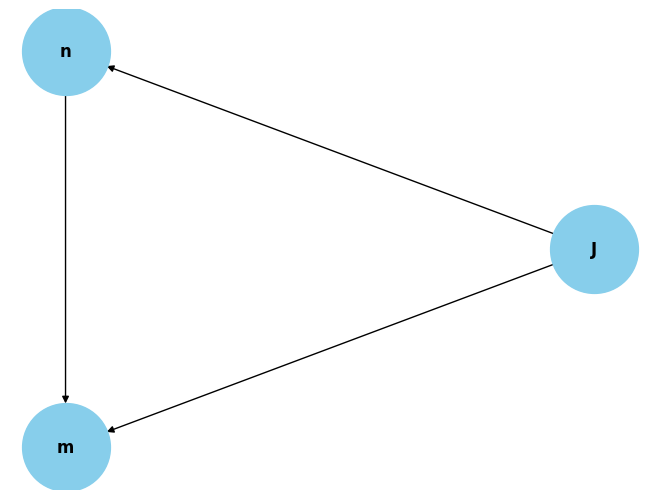

In [3]:
p = 1/2
q = 2/3
model = BayesianNetwork([('J', 'n'), ('J', 'm'), ('n', 'm')])  

cpd_j = TabularCPD(variable='J', variable_card=2, values=[[0.5], [0.5]])
cpd_n = TabularCPD(variable='n', variable_card=2, 
                   values=[[1-p, 1-q],         #n=0 (ban)
                           [p, q]],        #n=1 (stema)     
                  evidence=['J'],
                  evidence_card=[2])
cpd_m = TabularCPD(variable='m', variable_card=3, 
                   values=[[1-p, 1-q, (1-p)**2, (1-q)**2],         #m=0 
                           [p, q, 2*p*(1-p), 2*q*(1-q)],         #m=1
                           [0, 0, p**2, q**2]],            #m=2       
                  evidence=['n','J'],
                  evidence_card=[2,2])

model.add_cpds(cpd_j, cpd_n, cpd_m)
pos = nx.circular_layout(model)
nx.draw(model, pos=pos, with_labels=True, node_size=4000, font_weight='bold', node_color='skyblue')
plt.show()


In [4]:
#verificare
P = 0
for n in range(2):
        for m in range(n+1):
                P += model.get_state_probability({'n': n, 'm': m})
print('Probabilitatea ca J0 sa castige este', P)

Probabilitatea ca J0 sa castige este 0.5532407407407407


**3.**

In [5]:
infer = VariableElimination(model)
result = infer.query(variables=['J'], evidence={'m': 1})
print(result)

+------+----------+
| J    |   phi(J) |
+======+==========+
| J(0) |   0.4909 |
+------+----------+
| J(1) |   0.5091 |
+------+----------+


**Sub. 2**

In [6]:
import pymc as pm
import arviz as az
import pytensor

**1.**

In [7]:
# Generare date de simulare
timp_asteptare_obs = np.random.normal(5, 2, size=100)

**2.**

In [8]:
# Modelul PyMC
with pm.Model() as model:
    # Distributie a priori pentru timpul mediu de asteptare
    timp_mediu_asteptare = pm.Normal("timp_mediu_asteptare", mu=5, sigma=10)
    
    # Distributie a priori pentru deviatia standard
    deviatie_standard = pm.HalfNormal("deviatie_standard", sigma=5)
    
    # Modelul de observare
    observatii = pm.Normal("observatii", mu=timp_mediu_asteptare, sigma=deviatie_standard, observed=timp_asteptare_obs)
    
    # inferenta
    trace = pm.sample(1000, tune=1000)

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [timp_mediu_asteptare, deviatie_standard]


INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


**3.**

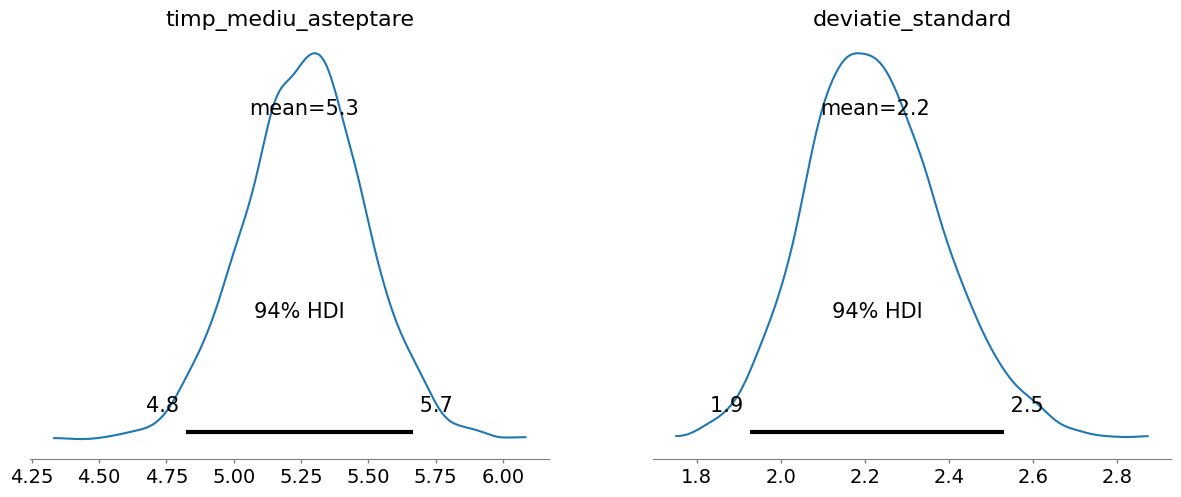

In [9]:
# Afisare rezultate
az.plot_posterior(trace)
plt.show()